## Gene body counts

In [1]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

sys.path.append('/home/camiel/chromograph/')
# from chromograph.plotting.UMI_plot import UMI_plot
import chromograph
from chromograph.peak_calling.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [2]:
## Import path to the relevant 10X reference dataset

ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
f = '/data/proj/scATAC/chromograph/build_20191205/Midbrain.loom'

pad = 2000

In [3]:
## Connect to loompy session
ds = loompy.connect(f, mode='r')
logging.info(ds.shape)

13:54:42 INFO     (617643, 9470)


In [4]:
os.listdir(os.path.join(ref, 'genes'))
# os.listdir(ref)

['regulatory.gff', 'genes.gtf']

In [5]:
tss = BedTool(os.path.join(ref, 'regions', 'tss.bed'))
genes = BedTool(os.path.join(ref, 'genes', 'genes.gtf'))

tss.head()

chr1	11868	11869	DDX11L1	.	+	transcribed_unprocessed_pseudogene
 chr1	12009	12010	DDX11L1	.	+	transcribed_unprocessed_pseudogene
 chr1	17435	17436	MIR6859-1	.	-	miRNA
 chr1	29553	29554	RP11-34P13.3	.	+	lincRNA
 chr1	29569	29570	WASH7P	.	-	unprocessed_pseudogene
 chr1	30266	30267	RP11-34P13.3	.	+	lincRNA
 chr1	30365	30366	MIR1302-2	.	+	miRNA
 chr1	36080	36081	FAM138A	.	-	lincRNA
 chr1	52472	52473	OR4G4P	.	+	unprocessed_pseudogene
 chr1	57597	57598	OR4G11P	.	+	transcribed_unprocessed_pseudogene
 

In [6]:
gb = []
for x in genes:
    if np.logical_and(x[2] == 'gene', x.attrs['gene_type'] == 'protein_coding'):
        gb.append(x)
        
gb = BedTool(gb)
print(len(gb))

if ds.attrs['reference_assembly'] == 'GRCh38':
    gb = gb.slop(s=True, l=pad, r=0, genome = 'hg38')
else:
    gb = gb.slop(s=True, l=pad, r=0, genome = ds.attrs['reference_assembly'])
gb.head()

19901
chr1	HAVANA	gene	63419	71585	.	+	.	gene_id "ENSG00000186092.6";gene_type "protein_coding";gene_name "OR4F5";level 2;havana_gene "OTTHUMG00000001094.4";
 chr1	HAVANA	gene	450703	453697	.	-	.	gene_id "ENSG00000284733.1";gene_type "protein_coding";gene_name "OR4F29";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002860.3";
 chr1	HAVANA	gene	685679	688673	.	-	.	gene_id "ENSG00000284662.1";gene_type "protein_coding";gene_name "OR4F16";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002581.3";
 chr1	HAVANA	gene	921928	944581	.	+	.	gene_id "ENSG00000187634.11";gene_type "protein_coding";gene_name "SAMD11";level 2;havana_gene "OTTHUMG00000040719.10";
 chr1	HAVANA	gene	944204	961309	.	-	.	gene_id "ENSG00000188976.10";gene_type "protein_coding";gene_name "NOC2L";level 2;havana_gene "OTTHUMG00000040720.1";
 chr1	HAVANA	gene	958587	965715	.	+	.	gene_id "ENSG00000187961.13";gene_type "protein_coding";gene_name "KLHL17";level 2;havana_gene "OTTHUMG00000040721.6";
 chr1	HAVAN

In [276]:
loc = [f'{x[0]}:{x[3]}-{x[4]}' for x in gb]
loc[:5]

['chr1:63419-71585',
 'chr1:450703-453697',
 'chr1:685679-688673',
 'chr1:921928-944581',
 'chr1:944204-961309']

In [55]:
# gb.saveas('/home/camiel/chromograph/chromograph/references/GRCh38_genes_2kbprom.bed')

<BedTool(/home/camiel/chromograph/chromograph/references/GRCh38_genes_2kbprom.bed)>

In [17]:
logging.info('start')
fragments = BedTool('/data/proj/chromium/10X232_4_A/outs/fragments.tsv.gz')
logging.info('loaded')

14:08:25 INFO     start
14:08:25 INFO     loaded


In [118]:
logging.info('filtering')
frags = fragments.filter(lambda x: x[3] in ds.ca['barcode']).saveas('/home/camiel/misc/temp.bed', compressed=True)

logging.info('Retrieving first fragment')
for x in frags[:1]:
    print(x)
    
logging.info('Printing length')
logging.info(f'Total fragments: {frags.count()}')

10:59:09 INFO     filtering
11:26:09 INFO     Retrieving first fragment
11:26:09 INFO     Printing length


chr1	16230	16261	TTCTAACAGGGCATTG-1	1



11:26:44 INFO     Total fragments: 6627883


In [18]:
# frags = fragments.filter(lambda x: x[3] == 'AACGAGGGTAATGTAG-1')
# for x in frags[:10]:
#     print(x)

In [100]:
meta = {'barcode': ds.ca['barcode']}

In [40]:
logging.info('Intersecting fragments with Genomic regions')
inter = gb.intersect(fragments, wa=True, wb=True)
logging.info('intersected')

14:26:01 INFO     Starting
14:26:17 INFO     intersected


In [105]:
def Count_genes(bars, intersections):
    '''
    '''
    Count_dict = {k: {} for k in bars}
    i = 0

    for x in intersections:

        bar = str(x[-2])
        g = x.attrs['gene_id']

        if bar in Count_dict:
            if g not in Count_dict[bar]:
                Count_dict[bar][g] = 1
            else:
                Count_dict[bar][g] += 1
        i += 1

        if i%1000000 == 0:
            logging.info(f'Counted {i/1000000} million transcripts')
            
    return Count_dict

Count_dict = Count_genes(meta['barcode'], inter)

16:50:46 INFO     1000000
16:51:06 INFO     2000000
16:51:26 INFO     3000000
16:51:45 INFO     4000000
16:52:05 INFO     5000000


In [99]:
r_dict = {k: [] for k in ['Accession', 'Gene']}
for x in gb:
    r_dict['Accession'].append(x.attrs['gene_id'])
    r_dict['Gene'].append(x.attrs['gene_name'])
    
g_dict = {k: v for v,k in enumerate(r_dict['Accession'])}

In [102]:
## Create sparse matrix
col = []
row = []
v = []

cix = 0
for cell in meta['barcode']:
    
    for key in (Count_dict[cell]):
        col.append(cix)
        row.append(g_dict[key])
        v.append(Count_dict[cell][key])
    cix+=1

matrix = sparse.coo_matrix((v, (row,col)), shape=(len(g_dict.keys()), len(meta['barcode'])))

In [103]:
matrix

<19901x9470 sparse matrix of type '<class 'numpy.int64'>'
	with 4575586 stored elements in COOrdinate format>

In [13]:
reg = BedTool(os.path.join(ref, 'genes', 'regulatory.gff'))
print(len(reg))
reg.head()

674905
chr1	Regulatory_Build	CTCF_binding_site	9801	10000	.	.	.	ID=CTCF_binding_site:ENSR00000344264;bound_end=10000;bound_start=9801;description=CTCF binding site;feature_type=CTCF Binding Site
 chr1	Regulatory_Build	CTCF_binding_site	13201	13600	.	.	.	ID=CTCF_binding_site:ENSR00000344265;bound_end=13600;bound_start=13201;description=CTCF binding site;feature_type=CTCF Binding Site
 chr1	Regulatory_Build	CTCF_binding_site	15401	16400	.	.	.	ID=CTCF_binding_site:ENSR00000344266;bound_end=16400;bound_start=15401;description=CTCF binding site;feature_type=CTCF Binding Site
 chr1	Regulatory_Build	CTCF_binding_site	17601	17800	.	.	.	ID=CTCF_binding_site:ENSR00000344267;bound_end=17800;bound_start=17601;description=CTCF binding site;feature_type=CTCF Binding Site
 chr1	Regulatory_Build	promoter_flanking_region	19715	23399	.	.	.	ID=promoter_flanking_region:ENSR00000000005;bound_end=23399;bound_start=19715;description=Predicted promoter flanking region;feature_type=Promoter Flanking Region
 ch

In [18]:
tmp = []
for x in reg:
    tmp.append(x[2])
    
print(np.unique(tmp))

['CTCF_binding_site' 'TF_binding_site' 'enhancer' 'open_chromatin_region'
 'promoter' 'promoter_flanking_region']


In [17]:
TFs = []
for x in reg:
    if x[2] == 'TF_binding_site':
        TFs.append(x)
    
TFs = BedTool(TFs)
print(len(TFs))
TFs.head()

29860
chr1	Regulatory_Build	TF_binding_site	134985	135420	.	.	.	ID=TF_binding_site:ENSR00000344287;bound_end=135420;bound_start=134985;description=Transcription factor binding site;feature_type=TF binding site
 chr1	Regulatory_Build	TF_binding_site	135991	138270	.	.	.	ID=TF_binding_site:ENSR00000000018;bound_end=138270;bound_start=135991;description=Transcription factor binding site;feature_type=TF binding site
 chr1	Regulatory_Build	TF_binding_site	138281	139624	.	.	.	ID=TF_binding_site:ENSR00000344288;bound_end=139624;bound_start=138281;description=Transcription factor binding site;feature_type=TF binding site
 chr1	Regulatory_Build	TF_binding_site	140078	140409	.	.	.	ID=TF_binding_site:ENSR00000344289;bound_end=140447;bound_start=139977;description=Transcription factor binding site;feature_type=TF binding site
 chr1	Regulatory_Build	TF_binding_site	185984	186349	.	.	.	ID=TF_binding_site:ENSR00000344296;bound_end=186761;bound_start=185827;description=Transcription factor binding site

In [11]:
cfr = BedTool(frags[0])

In [ ]:
vals = []

for x in range(ds.shape[1]):
    cfr = BedTool(frags[x])
    CB = coding.intersect(cfr, c=True)
    counts = [int(x[7]) for x in CB]
    vals.append(counts)

    if x%100 == 0:
        logging.info(f"finished {x}  cells")

20:02:33 INFO     finished 0  cells
20:05:45 INFO     finished 100  cells


In [28]:
len(vals)

4273

In [177]:
# ## Remove genes with non-unique names occuring on multiple chromosomes

# tmp = []
# for x in coding_collaps:
#     tmp.append(x[3])
    
# print(len(tmp), len(np.unique(tmp)))

# mults = collections.Counter(tmp)
# fix = []

# for k in mults:
#     if mults[k] > 1:
#         fix.append(k)
        
# newcoding=[]
# for x in coding:
#     if x[3] in fix:
#         continue
#     else:
#         newcoding.append(x)
    
# coding = BedTool(newcoding)
# coding_collaps = coding.groupby(g = [4,1], c = [2,3,4], o = ['min', 'max', 'count'], full=True)
# len(coding_collaps)

22518 21967


21439

In [178]:
         
def feature_count(data, coding, res):
    '''
    temporary
    '''    
    counts = coding.intersect(BedTool(data[1]), c=True)
    counts = np.array([int(x[7]) for x in counts])
    
    genes = []
    for x in coding:
        genes.append(x[3])
      
    count_dict = {}
    sel = counts > 0
    for k, v in zip(np.array(genes)[sel], counts[sel]):
        if k not in count_dict:
            count_dict[k] = v
        else:
            count_dict[k] += v
    
    res[data[0]] = count_dict
    return

In [179]:
genes = []
for x in coding:
    genes.append(x[3])

In [180]:
genes = []
for x in coding:
    genes.append(x[3])

res = {}

## Chunk by cell
frags = [strFrags_to_list(x) for x in ds.ca['fragments']]
chunks = [[k,v] for k,v in zip(ds.ca['cell_id'], frags)]

logging.info(f"Chunked data")

13:31:54 INFO     Chunked data


In [181]:
i = 0
logging.info(f"Started counting genes")
for chunk in chunks:
        feature_count(chunk, coding, res)
        
        i += 1
        
        if i%300 == 0:
            logging.info(f"processed {i} cells")

13:31:54 INFO     Started counting genes
13:43:02 INFO     processed 300 cells
13:54:17 INFO     processed 600 cells
14:05:40 INFO     processed 900 cells
14:17:01 INFO     processed 1200 cells
14:28:31 INFO     processed 1500 cells
14:41:20 INFO     processed 1800 cells
14:54:11 INFO     processed 2100 cells
15:07:01 INFO     processed 2400 cells
15:19:55 INFO     processed 2700 cells
15:32:56 INFO     processed 3000 cells
15:46:02 INFO     processed 3300 cells
15:59:05 INFO     processed 3600 cells
16:12:14 INFO     processed 3900 cells
16:25:23 INFO     processed 4200 cells


In [182]:
rows = {'Gene': [], 'N_TSS': []}

for x in coding_collaps:
    rows['Gene'].append(x[3])
    rows['N_TSS'].append(x[9])
    
logging.info(f"Extracted coding genes to dict")

g_ref = {}
for x,k in enumerate(rows['Gene']):
    g_ref[k] = x

16:28:33 INFO     Extracted coding genes to dict


In [183]:
print(len(genes), len(np.unique(genes)), len(coding_collaps))

SyntaxError: unexpected EOF while parsing (<ipython-input-183-334655d1bb62>, line 1)

In [113]:
## Create sparse matrix
col = []
row = []
val = []

cix = 0
for cell in res:
    
    for key in res[cell]:
        col.append(cix)
        row.append(g_ref[key])
        val.append(res[cell][key])
    cix+=1
    
matrix = sparse.coo_matrix((val, (row,col)), shape=(len(rows['Gene']), len(ds.ca['cell_id'])))
matrix

<22518x4273 sparse matrix of type '<class 'numpy.int64'>'
	with 18356269 stored elements in COOrdinate format>

In [125]:
dsg.close()

In [124]:
f_out = f.split('_')[:-1]
f_out = '_'.join(f_genes) + "_tss.loom"

col_attrs = dict(ds.ca)
f_attrs = dict(ds.attrs)

loompy.create(filename=f_out, 
              layers=matrix, 
              row_attrs=rows, 
              col_attrs=col_attrs,
              file_attrs=f_attrs)

In [126]:
dsg = loompy.connect(f_out)
dsg.shape

(22518, 4273)

In [ ]:
## Smoothing matrix

##

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

def feature_plot(ds: loompy.LoomConnection, out_file: str, markers : list, embedding: str = "TSNE") -> None:
    '''
    Generates a multi-panel plot to inspect UMI and Bin counts.
    
    Args:
        ds                    Connection to the .loom file to use
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    

    Ylen = np.ceil(len(markers) / 3)
    
    fig = plt.figure(figsize=(Ylen*7, 21))
    fig.subplots_adjust(hspace=.1, wspace=.1)
    
    
    for i in range(1, len(markers) + 1):
        ax = fig.add_subplot(Ylen, 3, i)
    
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        gene = markers[i-1]
        exp = np.log1p(ds[ds.ra['Gene'] == gene,:].flatten())
#         exp = ds[ds.ra['Gene'] == gene,:].flatten()
        k = exp > 0
            
        ax.scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], c='lightgrey', marker='.', lw=0, s=epsilon)
        im = ax.scatter(ds.ca[embedding][k,0],ds.ca[embedding][k,1], c=exp[k], cmap='viridis', marker='.', lw=0, s=epsilon+1)

        fig.colorbar(im, orientation='vertical', ax=ax)
        ax.set_title(f"{gene}")
        ax.axis("off")
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

In [135]:
print(len(dsg.ra['Gene']))
print(len(np.unique(dsg.ra['Gene'])))
print(len(rows['Gene']))

22518
21967
22518


In [128]:
markers = ['Otx2', 'Snap25', 'Gad2', 'Igfbp2', 'C1qb', 'Reln', 'Neurod6', 'Apoe', 'Gfap', 'Aqp4', 'Olig2', 'Plp1']

In [131]:
dsg.ca['TSNE'].shape

(4273, 2)

In [129]:
f_plot = f.split('_')[:-1]
f_TSNE = '_'.join(f_plot) + '_genes_tSNE.png'
f_UMAP = '_'.join(f_plot) + '_genes_UMAP.png'

feature_plot(dsg, f_TSNE, dsg.ra['Gene'], embedding = 'TSNE')
feature_plot(dsg, f_UMAP, dsg.ra['Gene'], embedding = 'UMAP')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4273 but corresponding boolean dimension is 8546

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2b432ed7f9e0> (for post_execute):


ValueError: Image size of 3783024x1512 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 3783024x1512 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3.78302e+06x1512 with 9 Axes>

# TEMPORARY MERGE

In [133]:
f = ['/data/proj/scATAC/chromograph/10X232_3/10X232_3_GA.loom', '/data/proj/scATAC/chromograph/10X232_4/10X232_4_GA.loom']

# ds1 = loompy.connect('/data/proj/scATAC/chromograph/10X232_3/10X232_3_GA.loom')
# ds2 = loompy.connect('/data/proj/scATAC/chromograph/10X232_4/10X232_4_GA.loom')

# ds = loompy.combine(f, key = 'Accession', output_file = '/data/proj/scATAC/chromograph/build_20200121/Midbrain_GA.loom')
ds = loompy.connect('/data/proj/scATAC/chromograph/build_20200121/Midbrain_GA.loom')

In [130]:
dsb = loompy.connect('/data/proj/scATAC/chromograph/build_20191205/Midbrain.loom', 'r')

In [170]:
print(ds.shape, dsb.shape)

(19901, 9452) (617643, 9470)


In [165]:
c1 = [ds.ca['sample'][x] + '_' + ds.ca['barcode'][x] for x in range(ds.shape[1])]
c2 = [dsb.ca['sample'][x] + '_' + dsb.ca['barcode'][x] for x in range(dsb.shape[1])]

In [283]:
m = [x for x in c2 if x in c1]
k = [x in m for x in c2]
cols = {}
cgraphs = {}
for x in dsb.ca:
    cols[x] = dsb.ca[x][k]

for x in dsb.col_graphs:
    cgraphs[x] = dsb.col_graphs[x][k]

TypeError: 'coo_matrix' object is not subscriptable

In [281]:
for x in dsb.col_graphs:
    print(x)

KNN
MKNN
RNN


In [192]:
for x in cols:
    if x not in ds.ca:
        ds.ca[x] = cols[x]

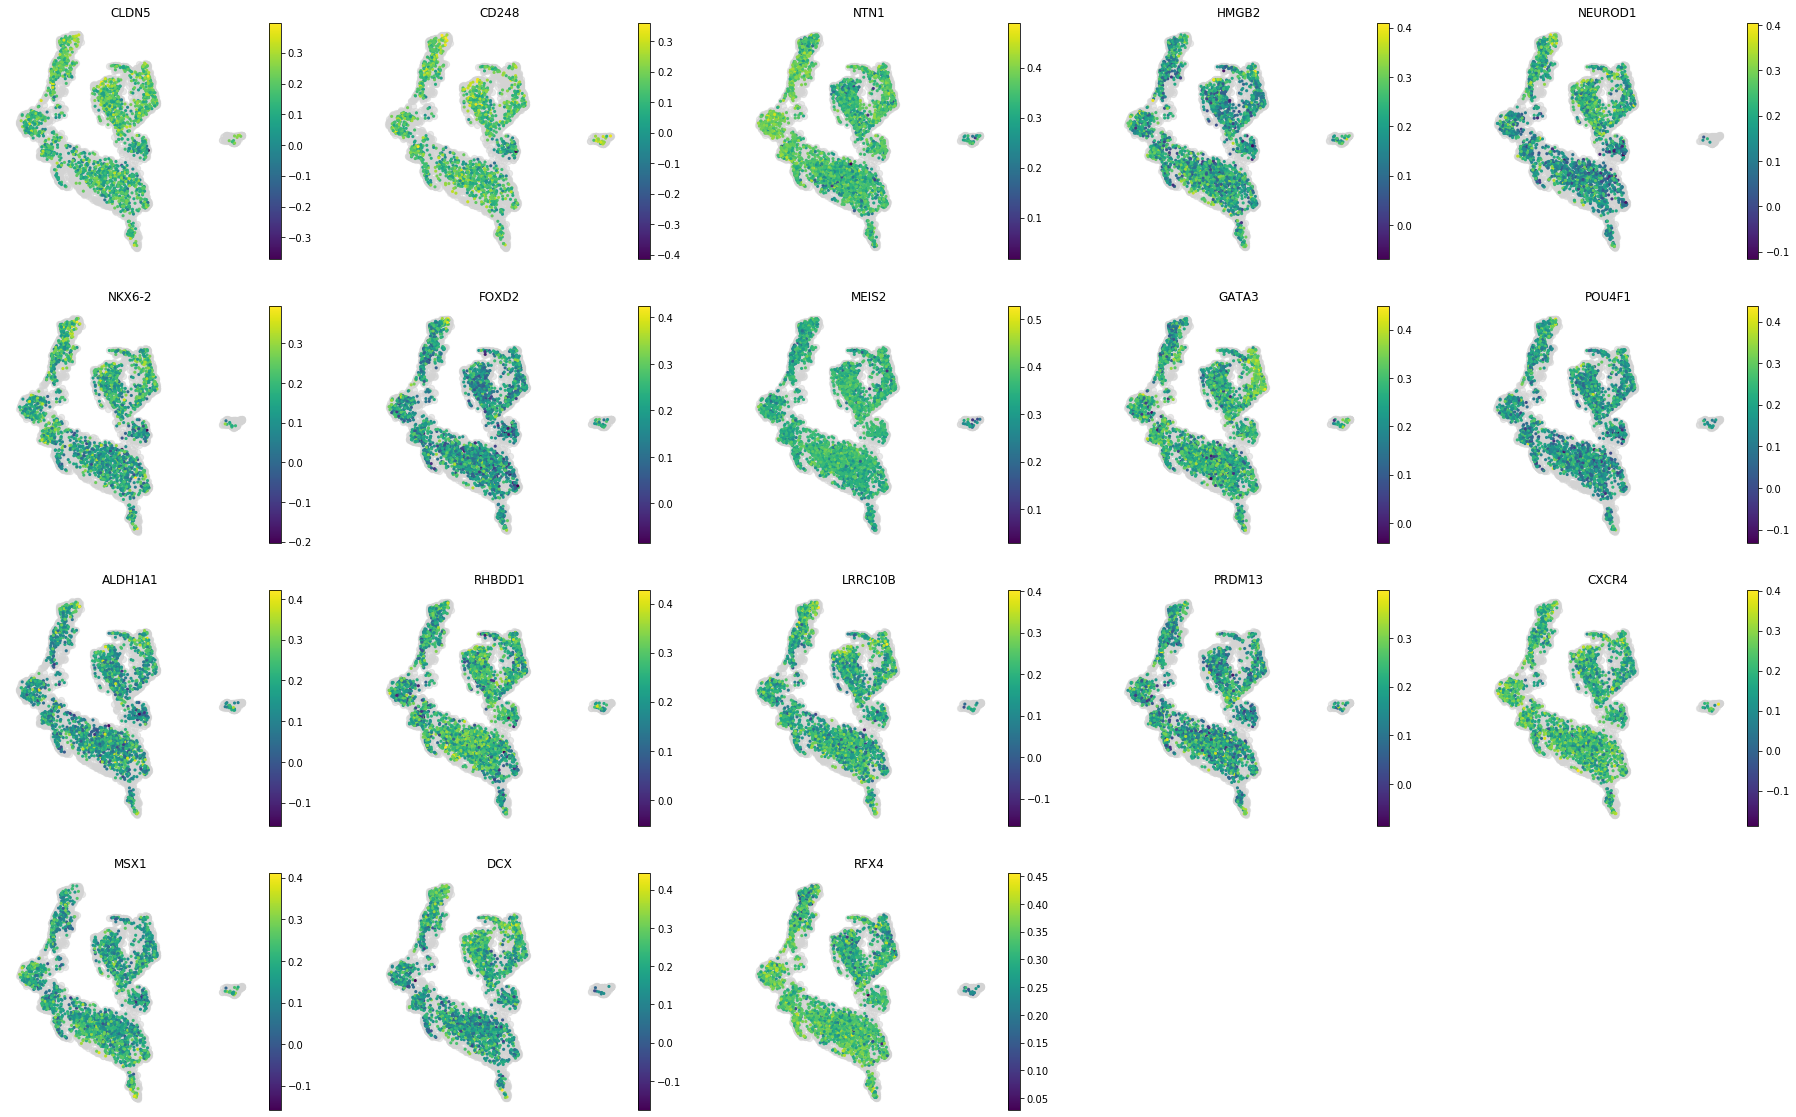

In [253]:
import matplotlib.pyplot as plt
import numpy as np
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

def marker_plot(ds: loompy.LoomConnection, out_file: str, markers: list, embedding: str = "TSNE") -> None:
    '''
    Generates a multi-panel plot to inspect UMI and Bin counts.
    
    Args:
        ds                    Connection to the .loom file to use
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    nM = len(markers)
    
    fig = plt.figure(figsize=(np.ceil(nM/5)*8, 20))
    
    i = 1
    for m in markers:
        ax = fig.add_subplot(np.ceil(nM/5), 5, i)
        
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        ## GA score    
        v = ds[ds.ra['Gene'] == m, :][0]
        k = v > 0
        GA = np.log10(v[k] / (ds.ca['passed_filters'][k]*1e-6))
        
        ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
        im = ax.scatter(pos[k,0], pos[k,1], cmap='viridis', c=np.log10(GA), marker='.', lw=0, s=epsilon)
        
        fig.colorbar(im, ax=ax, orientation='vertical')
        ax.set_title(f'{m}')
        ax.axis("off")
        
        i += 1
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

markers = ['CLDN5', 'CD248', 'NTN1', 'HMGB2', 'NEUROD1', 'NKX6-2', 'FOXD2', 'MEIS2', 'GATA3', 'POU4F1', 'ALDH1A1', 'RHBDD1', 'LRRC10B', 'PRDM13', 'CXCR4', 'MSX1', 'DCX', 'RFX4']

marker_plot(ds, 'tmp', markers = markers, embedding = 'UMAP')

In [269]:
print(sum(ds.ca['passed_filters']>100000))
print(sum(ds.ca['passed_filters']<5000))
print(sum(ds.ca['passed_filters']<10000))
print(min(ds.ca['passed_filters']))
print('.')
print(sum(dsb.ca['passed_filters']>100000))
print(sum(dsb.ca['passed_filters']<5000))
print(sum(dsb.ca['passed_filters']<10000))
print(min(dsb.ca['passed_filters']))

807
0
271
5030
.
808
17
288
3773


In [271]:
for x in ds.ca:
    print(f'{x}: {ds.ca[x][0]}')

DNase_sensitive_region_fragments: 31566
TSS_fragments: 21662
barcode: AAACGAAAGAAATTCG-1
blacklist_region_fragments: 3
cell_id: _cell_0
chimeric: 1308
duplicate: 58461
enhancer_region_fragments: 9184
is__cell_barcode: 1
lowmapq: 7667
mitochondrial: 6
on_target_fragments: 38725
passed_filters: 52051
peak_region_cutsites: 62605
peak_region_fragments: 32364
promoter_region_fragments: 20785
sample: 10X232_3
total: 120838
unmapped: 1345
Clusters: 0
ClustersModularity: 0
ClustersSurprise: 1
HPF: [2.38598271e-02 4.82802757e-03 7.86203501e-03 5.81836940e-02
 1.29679105e-02 1.07189583e-01 5.78568803e-03 3.81942486e-03
 2.73397081e-03 2.17407448e-04 8.33254345e-02 4.91714181e-02
 8.71781971e-03 3.46620631e-03 3.80388119e-02 6.18423447e-02
 1.43517986e-02 4.37857654e-02 1.50532477e-02 6.86352120e-03
 2.98595788e-02 7.21430401e-03 8.31676811e-03 1.70003837e-03
 5.36664074e-03 1.79735871e-05 2.44225851e-03 6.81233534e-03
 3.46585373e-03 1.55516504e-03 2.31537287e-02 2.10679915e-02
 3.21520096e-03 3

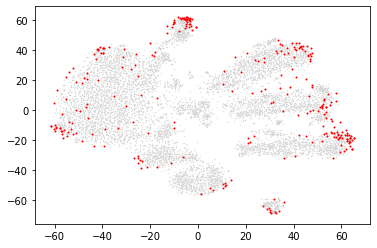

In [268]:
plt.scatter(dsb.ca['TSNE'][:,0], dsb.ca['TSNE'][:,1], c='lightgrey', s=0.1)
plt.scatter(dsb.ca['TSNE'][:,0][dsb.ca['passed_filters']<10000], dsb.ca['TSNE'][:,1][dsb.ca['passed_filters']<10000], c='red', s=1)

In [277]:
g = ds.col_graphs['MKNN'].toarray()
smooth = []
batch = 10000

# Parallel version
# @jit(parallel=True)
@njit
def smooth_bins_jit(data, g) -> None:
    '''
    '''
    y = []
    for x in numba.prange(data.shape[1]):
        nn = g[:,x]>0
        nn_n = np.sum(nn)
        v = data[:,x] + np.sum(data[:,nn], axis=1) / (nn_n+1)
        y.append(v)
        
    return y

ds.shape

AttributeError: '<class 'loompy.graph_manager.GraphManager'>' object has no graph 'MKNN' on axis 1

In [ ]:
ds['smooth'] = 'float32'
for (ix, selection, view) in ds.scan(axis=0, batch_size=batch):
    g = view.col_graphs['KNN'].toarray()
    vals = smooth_bins_jit(view[blayer][:,:], g)
    vals = np.vstack(vals)
    ds['smooth'][ix:vals.shape[1],:] = vals.T
    if ix %(batch*5) == 0:
        logging.info(f"finished{ix} rows")

(array([ 47876.,   3558.,   2930.,   3422.,  10576., 162074., 242275.,
         90717.,  34248.,  19967.]),
 array([-2.94143217e+00, -2.45077959e+00, -1.96012701e+00, -1.46947442e+00,
        -9.78821842e-01, -4.88169259e-01,  2.48332383e-03,  4.93135907e-01,
         9.83788489e-01,  1.47444107e+00,  1.96509365e+00]),
 <a list of 10 Patch objects>)

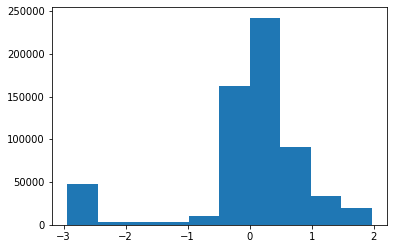

In [289]:
cov = np.log10(dsb.ra['NCells']+1)
mu = np.mean(cov)
sd = np.std(cov)
Z = (cov - mu) / sd

plt.hist(Z)